In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis

In [9]:
data_dir = Path("../data/first_dataset_initial_filtering")
pkl_files = sorted(data_dir.glob("*.pkl"))

dfs = [pd.read_pickle(f) for f in pkl_files]

In [10]:
dfs[18].head()

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030


In [11]:
timeline_df = pd.read_csv("../audio-timeline.csv")
# Converte colunas de timestamp para segundos
def hms_to_seconds(hms_str):
    h, m, s = map(int, hms_str.strip().split(":"))
    return h * 3600 + m * 60 + s

for col in ["sequence1", "sequence2", "sequence3"]:
    timeline_df[f"{col}_sec"] = timeline_df[col].apply(hms_to_seconds)

# Visualiza com as novas colunas
timeline_df

,target,sequence1,sequence2,sequence3,sequence1_sec,sequence2_sec,sequence3_sec
0,0,0:00:06,0:00:50,0:01:34,6,50,94
1,1,0:00:10,0:00:56,0:01:39,10,56,99
2,2,0:00:16,0:01:00,0:01:45,16,60,105
3,3,0:00:23,0:01:07,0:01:52,23,67,112
4,4,0:00:29,0:01:13,0:01:58,29,73,118
5,5,0:00:36,0:01:20,0:02:04,36,80,124
6,6,0:00:43,0:01:27,0:02:13,43,87,133


In [12]:
# List that will store the new DataFrames with target column
dfs_with_targets = []

# For each df (one block)
for df in dfs:
    df_new = df.copy()

    # Initialize target column as NaN
    df_new["target"] = None

    # Iterate through timeline
    for i, row in timeline_df.iterrows():
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence1_sec"]
        end = row["sequence1_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

        # Repeat for sequence2
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence2_sec"]
        end = row["sequence2_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

        # Repeat for sequence3
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence3_sec"]
        end = row["sequence3_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

    # Ensure target is integer
    df_new["target"] = df_new["target"].astype("Int64")

    dfs_with_targets.append(df_new)


In [13]:
dfs_with_targets[18]

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119,0
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997,0
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984,0
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008,0
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16666,246.0,18.300290,10.744635,-4.759181,5.513199,5.634423,-8.087288,18.896845,-50.822310,34.665678,33.452099,16.427773,28.941127,6.884469,21.599503,1.747692e+09,0.0,133.267526,0.008001,<NA>
16667,248.0,8.049270,2.042364,-7.596102,-2.561690,1.115842,-16.034833,14.925883,-40.740131,16.284212,8.963090,1.020426,11.656175,-2.360205,4.472622,1.747692e+09,0.0,133.275622,0.008096,<NA>
16668,250.0,13.555044,10.015143,4.261118,11.999589,4.567227,-4.996574,21.370714,-36.614406,22.615134,18.280704,8.893716,23.207279,9.441677,15.427447,1.747692e+09,0.0,133.282589,0.006967,<NA>
16669,252.0,38.705392,38.637390,20.551810,41.273656,17.534921,27.947119,41.313717,-45.729686,64.524370,67.312764,43.817244,62.172341,32.730838,53.473925,1.747692e+09,0.0,133.291615,0.009026,<NA>


In [14]:
max_music_duration = 133.0  # seconds

dfs_trimmed = [df[df["time_sec"] <= max_music_duration].copy() for df in dfs_with_targets]
dfs_trimmed[18]

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119,0
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997,0
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984,0
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008,0
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16628,170.0,-10.245404,-5.681293,1.173135,-4.495413,-6.434117,-0.858895,-1.997253,11.038639,-3.242737,-4.976824,-1.988229,-4.465390,0.836800,-5.154018,1.747692e+09,0.0,132.965423,0.007985,6
16629,172.0,-12.296817,-6.224449,-4.924857,-7.933979,-6.461799,-0.527775,-7.851352,9.049686,-6.564712,-10.548799,-8.922902,-13.468666,-7.661604,-13.548278,1.747692e+09,0.0,132.974486,0.009063,6
16630,174.0,-11.408842,-6.291086,-4.892649,-6.707653,-2.763055,2.861691,-6.164184,12.421679,-9.014616,-11.416326,-9.342240,-13.107019,-8.610103,-12.450487,1.747692e+09,0.0,132.982500,0.008014,6
16631,176.0,-9.324074,-5.668038,-2.700583,-2.657402,-0.668051,0.766055,2.890646,14.415933,-4.179630,-4.882257,-3.884029,-5.754288,-2.253366,-3.621695,1.747692e+09,0.0,132.990548,0.008048,6


In [15]:
# Filter all blocks, removing rows with target == 0
dfs_no_target_0 = [df[df["target"] != 0].copy() for df in dfs_trimmed]
dfs_no_target_0[18]


,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
751,160.0,4.648765,7.425719,6.187098,5.662294,3.598167,20.212209,-0.846586,-2.560603,1.611061,1.256217,2.608183,4.761602,6.940722,2.956699,1.747692e+09,0.0,6.004982,0.007967,1
752,162.0,1.869183,4.688483,5.721914,6.637207,4.668509,-0.747465,-2.772198,-2.300413,1.532534,3.606452,2.688025,5.858570,7.789084,3.132108,1.747692e+09,0.0,6.013063,0.008081,1
753,164.0,4.953371,6.928469,7.430552,7.289979,11.537378,-11.560196,-2.967949,-0.298426,5.137756,5.766060,5.000048,10.720159,9.569045,6.878705,1.747692e+09,0.0,6.021028,0.007965,1
754,166.0,8.686257,9.320479,7.141610,7.510423,10.359865,-6.674401,-6.313351,0.423021,9.041574,5.680081,7.078761,10.373154,7.460221,7.043760,1.747692e+09,0.0,6.032082,0.011054,1
755,168.0,8.875100,8.247527,8.920232,11.515157,6.673360,-4.898628,-8.539462,3.446222,10.395597,6.038059,8.040103,5.170913,1.072928,5.916785,1.747692e+09,0.0,6.038088,0.006006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16628,170.0,-10.245404,-5.681293,1.173135,-4.495413,-6.434117,-0.858895,-1.997253,11.038639,-3.242737,-4.976824,-1.988229,-4.465390,0.836800,-5.154018,1.747692e+09,0.0,132.965423,0.007985,6
16629,172.0,-12.296817,-6.224449,-4.924857,-7.933979,-6.461799,-0.527775,-7.851352,9.049686,-6.564712,-10.548799,-8.922902,-13.468666,-7.661604,-13.548278,1.747692e+09,0.0,132.974486,0.009063,6
16630,174.0,-11.408842,-6.291086,-4.892649,-6.707653,-2.763055,2.861691,-6.164184,12.421679,-9.014616,-11.416326,-9.342240,-13.107019,-8.610103,-12.450487,1.747692e+09,0.0,132.982500,0.008014,6
16631,176.0,-9.324074,-5.668038,-2.700583,-2.657402,-0.668051,0.766055,2.890646,14.415933,-4.179630,-4.882257,-3.884029,-5.754288,-2.253366,-3.621695,1.747692e+09,0.0,132.990548,0.008048,6


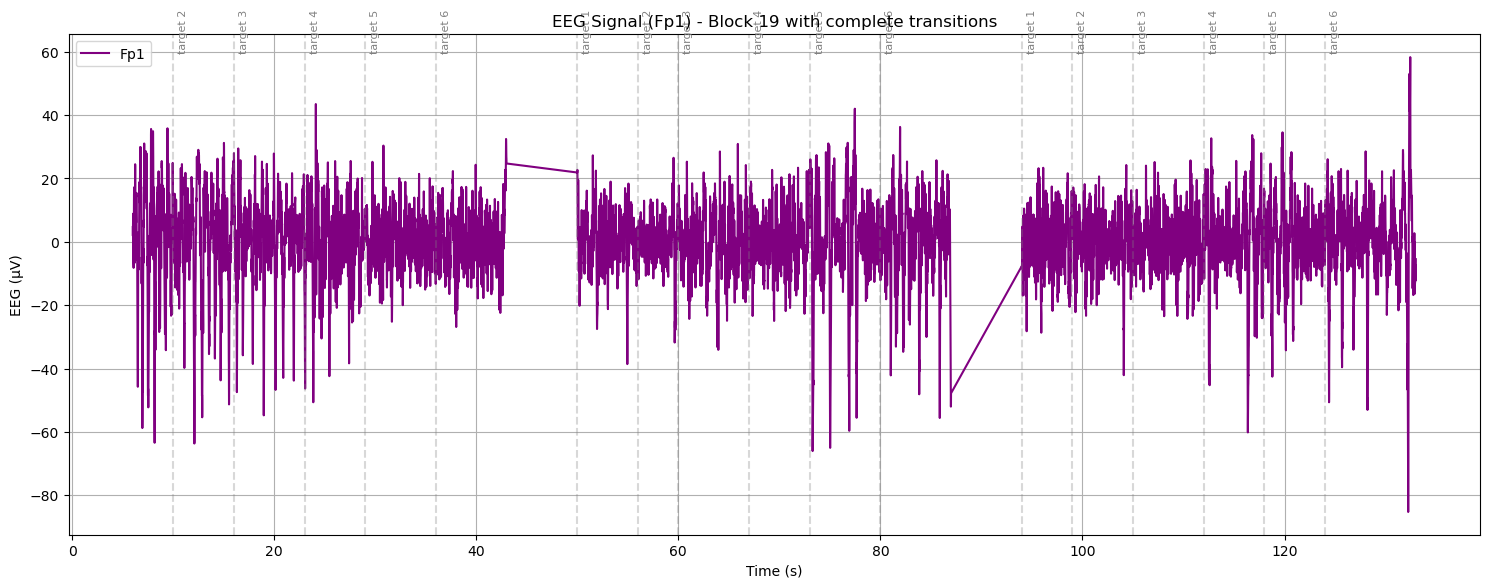

In [16]:
df_plot = dfs_no_target_0[18]

plt.figure(figsize=(15, 6))
plt.plot(df_plot["time_sec"], df_plot["Fp1"], label="Fp1", color="purple")

# Identify where target changes
transitions = df_plot["target"].ne(df_plot["target"].shift())
transition_points = df_plot[transitions]

# Mark all transitions with vertical lines
for _, row in transition_points.iterrows():
    t = row["target"]
    t_time = row["time_sec"]
    plt.axvline(t_time, color="gray", linestyle="--", alpha=0.3)
    plt.text(t_time + 0.5, 60, f"target {t}", fontsize=8, color="gray", rotation=90)

plt.title("EEG Signal (Fp1) - Block 19 with complete transitions")
plt.xlabel("Time (s)")
plt.ylabel("EEG (µV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


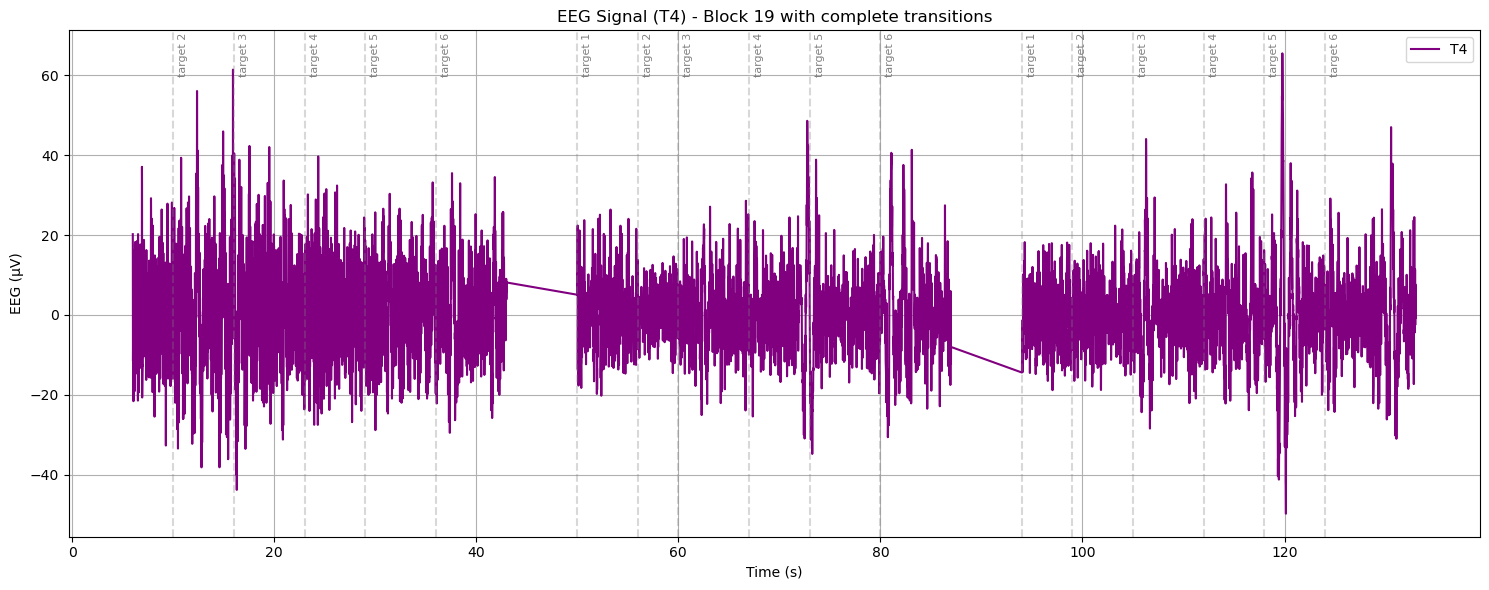

In [17]:
df_plot = dfs_no_target_0[18]

plt.figure(figsize=(15, 6))
plt.plot(df_plot["time_sec"], df_plot["T4"], label="T4", color="purple")

# Identify where target changes
transitions = df_plot["target"].ne(df_plot["target"].shift())
transition_points = df_plot[transitions]

# Mark all transitions with vertical lines
for _, row in transition_points.iterrows():
    t = row["target"]
    t_time = row["time_sec"]
    plt.axvline(t_time, color="gray", linestyle="--", alpha=0.3)
    plt.text(t_time + 0.5, 60, f"target {t}", fontsize=8, color="gray", rotation=90)

plt.title("EEG Signal (T4) - Block 19 with complete transitions")
plt.xlabel("Time (s)")
plt.ylabel("EEG (µV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## KNN (K-Nearest Neighbors)

**What it is:**

A simple, non-parametric classifier that predicts the label of a sample based on the majority label among its k nearest neighbors (in feature space).

**Why use it:**

- Very simple and straightforward
- Serves as a control: if it already classifies well, the data has basic separability
- Acts as a baseline: if KNN performs above chance, there is likely some structure in the data.
- Reacts quickly to overfitting → good indicator of feature quality
- Sensitive to how features are scaled and clustered.
- Helps visualize how similar EEG feature vectors are across different targets.

**Goal in this project:**

To check whether EEG windows related to different phrases form dense clusters in feature space.

In [18]:
# Parameters
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]


def extract_features(df_window, fs=125):
    features = {}
    for ch in eeg_channels:
        signal = df_window[ch].values

        # Simple statistics
        features[f"{ch}_mean"] = np.mean(signal)
        features[f"{ch}_std"] = np.std(signal)
        features[f"{ch}_skew"] = skew(signal)
        features[f"{ch}_kurt"] = kurtosis(signal)

        # Band power (alpha)
        f, psd = welch(signal, fs=fs, nperseg=128)
        alpha_band = (f >= 8) & (f <= 12)
        features[f"{ch}_alpha"] = np.trapz(psd[alpha_band], f[alpha_band])

    return features


In [19]:
window_size = 2  # segundos
fs = 125
samples_per_window = window_size * fs

feature_rows = []

for df in dfs_no_target_0:
    for i in range(0, len(df), samples_per_window):
        df_window = df.iloc[i:i+samples_per_window]
        if len(df_window) < samples_per_window:
            continue
        target = df_window["target"].iloc[0]
        row = extract_features(df_window, fs=fs)
        row["target"] = target
        feature_rows.append(row)

df_features = pd.DataFrame(feature_rows)


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3187937389.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features[f"{ch}_alpha"] = np.trapz(psd[alpha_band], f[alpha_band])


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = df_features.drop(columns=["target"])
y = df_features["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.23      0.43      0.30        28
           2       0.19      0.29      0.23        34
           3       0.22      0.26      0.24        46
           4       0.16      0.14      0.15        36
           5       0.23      0.12      0.16        40
           6       0.40      0.10      0.16        40

    accuracy                           0.21       224
   macro avg       0.24      0.22      0.21       224
weighted avg       0.24      0.21      0.20       224



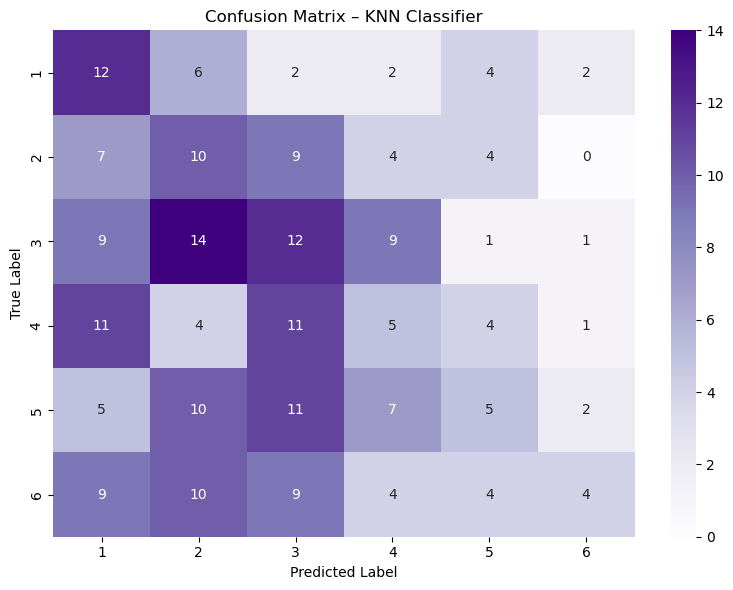

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))

# Create a labeled heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.sort(y.unique()),
            yticklabels=np.sort(y.unique()))

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – KNN Classifier")
plt.tight_layout()
plt.show()


## Logistic Regression

**What it is:**

A linear model that finds boundaries between classes by estimating the probability that a sample belongs to each class.

**Why use it:**

- Fast and interpretable.
- Establishes a baseline for linearly separable patterns.
- Can work well with normalized, handcrafted features.

**Goal in this project:**

To detect whether the EEG features contain enough linear structure to distinguish between different phrase segments.

In [22]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression (multinomial for multi-class)
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.32      0.32      0.32        28
           2       0.28      0.21      0.24        34
           3       0.20      0.22      0.21        46
           4       0.23      0.14      0.17        36
           5       0.17      0.20      0.18        40
           6       0.22      0.28      0.24        40

    accuracy                           0.22       224
   macro avg       0.24      0.23      0.23       224
weighted avg       0.23      0.22      0.22       224



/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


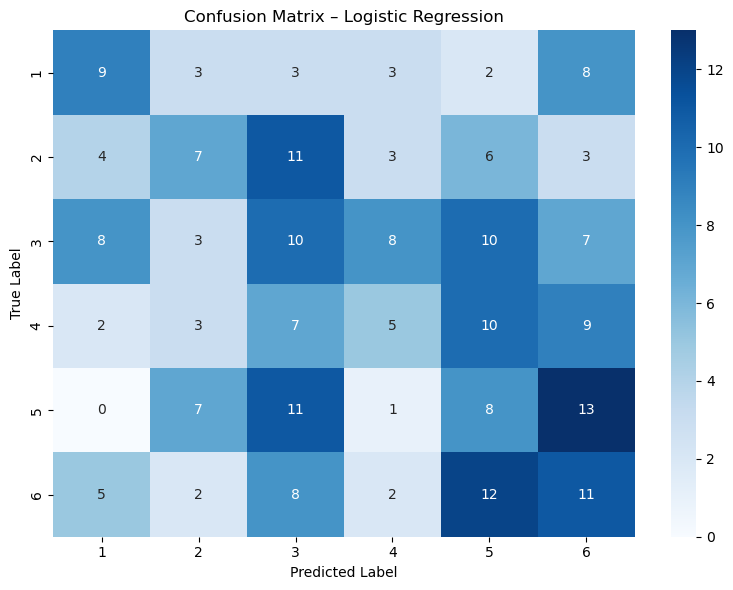

In [23]:
# Generate the confusion matrix
labels = np.sort(y.unique())  # to ensure order is [1, 2, 3, 4, 5, 6]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


## Random Forest

**What it is:**

An ensemble learning method that builds multiple decision trees and combines their outputs. It handles non-linear relationships and interactions between features.

**Why use it:**

- More powerful than linear models for discovering complex patterns.
- Offers built-in feature importance analysis.
- Robust to noise and unbalanced data.

**Goal in this project:**

To both classify phrase-related EEG patterns and reveal which features (channels, statistics, frequency bands) contribute most to the classification.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the model with normalized data (can use non-scaled data too - RF doesn't require scaling)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.15      0.07      0.10        28
           2       0.28      0.21      0.24        34
           3       0.24      0.41      0.31        46
           4       0.15      0.14      0.14        36
           5       0.36      0.35      0.35        40
           6       0.17      0.15      0.16        40

    accuracy                           0.24       224
   macro avg       0.23      0.22      0.22       224
weighted avg       0.23      0.24      0.23       224



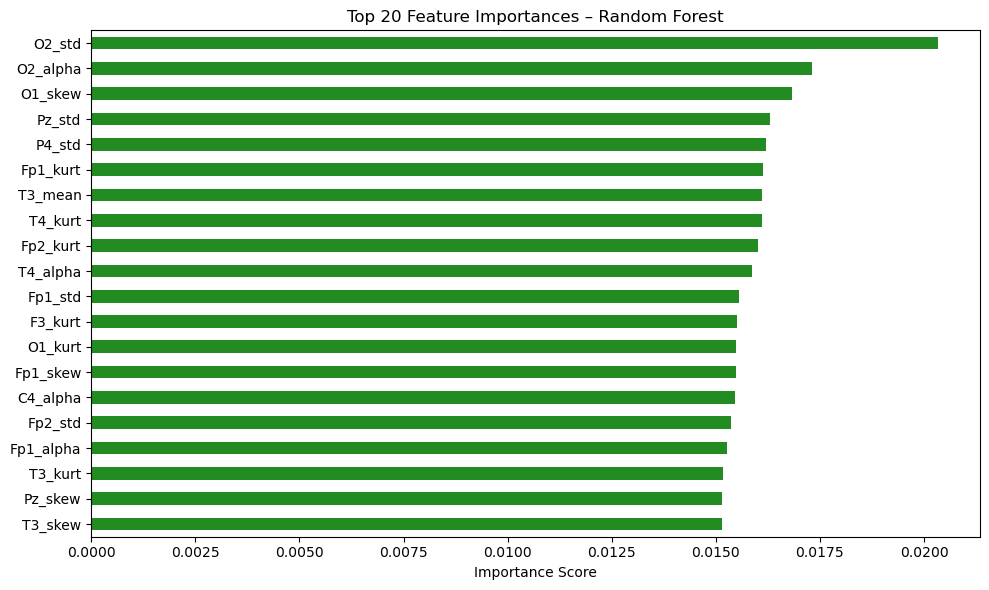

In [25]:
# Organize feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
top_features.plot(kind="barh", color="forestgreen")
plt.title("Top 20 Feature Importances – Random Forest")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## What can SVM offer at this stage?

Support Vector Machines (SVMs) are powerful tools for testing the shape and complexity of class separation in a feature space. In the context of Creativity in Vitro, using an SVM helps explore whether the EEG-based representations of phrases are linearly or non-linearly separable.

1. It tests for non-linear separation between phrases
Unlike Logistic Regression, which can only draw straight (linear) decision boundaries, an SVM with an RBF ('rbf') kernel can draw curved, flexible boundaries in the feature space.

It tries to maximize the margin between classes. This means that even when data points are closely packed or overlapping, the SVM can find functional decision surfaces if they exist.

2. It works well with small datasets
SVMs are especially useful when you don’t have thousands of training examples per class.
This matches your context, where each phrase (target class) has a limited number of samples.

It helps answer the question:

“Is there a subtle boundary that linear models cannot detect?”


- If the SVM outperforms Logistic Regression, it's strong evidence that the separation between phrase targets is non-linear.

- If it performs similarly or worse, it means your current features are already well represented linearly, which is a great insight!

- In either case, SVM serves as a probe into the shape of your data's structure — whether it’s a straight boundary or a curve hidden in multidimensional space.

In [26]:
from sklearn.svm import SVC

# Train SVM with RBF kernel (non-linear)
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

# Evaluation
print("Classification Report – SVM (RBF Kernel)")
print(classification_report(y_test, y_pred))

Classification Report – SVM (RBF Kernel)
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        28
           2       0.27      0.21      0.23        34
           3       0.26      0.52      0.35        46
           4       0.16      0.08      0.11        36
           5       0.26      0.23      0.24        40
           6       0.16      0.20      0.18        40

    accuracy                           0.23       224
   macro avg       0.18      0.21      0.18       224
weighted avg       0.20      0.23      0.20       224



In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the SVM with pipeline (scaler + model)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Define parameter grid
param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale'],
    'svm__degree': [2, 3, 4]  # Only used for 'poly' kernel
}

# Set up the GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

# Fit
grid.fit(X_train, y_train)

# Best model
print("Best parameters:", grid.best_params_)
print("Best F1-macro score:", grid.best_score_)

# Predict using the best estimator
y_pred = grid.best_estimator_.predict(X_test)

# Report
print("\nClassification Report – Best SVM from GridSearch")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END svm__C=0.1, sv

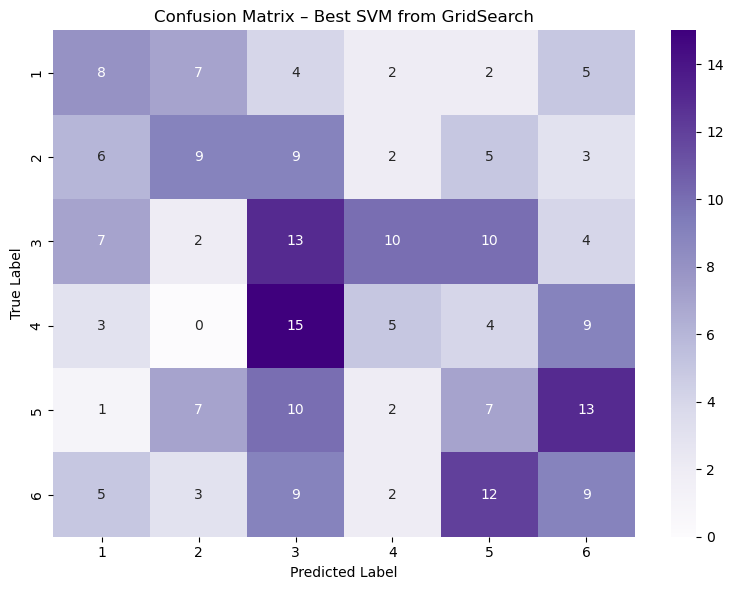

In [28]:
# Create the confusion matrix
labels = np.sort(y.unique())  # Ensure order is 1 to 6
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Best SVM from GridSearch")
plt.tight_layout()
plt.show()


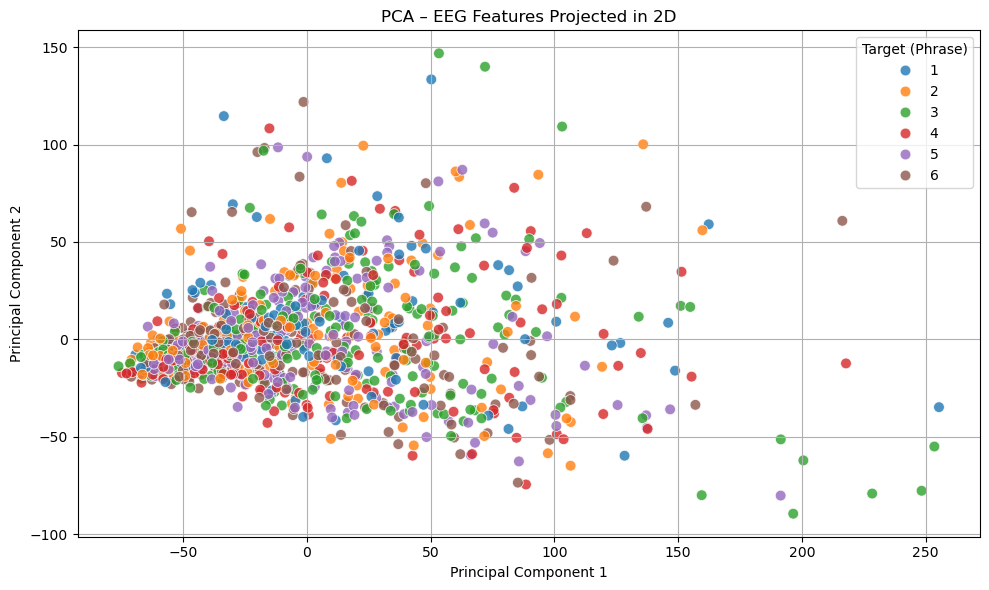

In [29]:
from sklearn.decomposition import PCA

# Prepare feature matrix (X) and labels (y)
X_pca = df_features.drop(columns=["target"])
y_pca = df_features["target"]

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca)

# Create a DataFrame for visualization
df_pca = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
df_pca["target"] = y_pca

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="target", palette="tab10", s=60, alpha=0.8)
plt.title("PCA – EEG Features Projected in 2D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Target (Phrase)")
plt.grid(True)
plt.tight_layout()
plt.show()


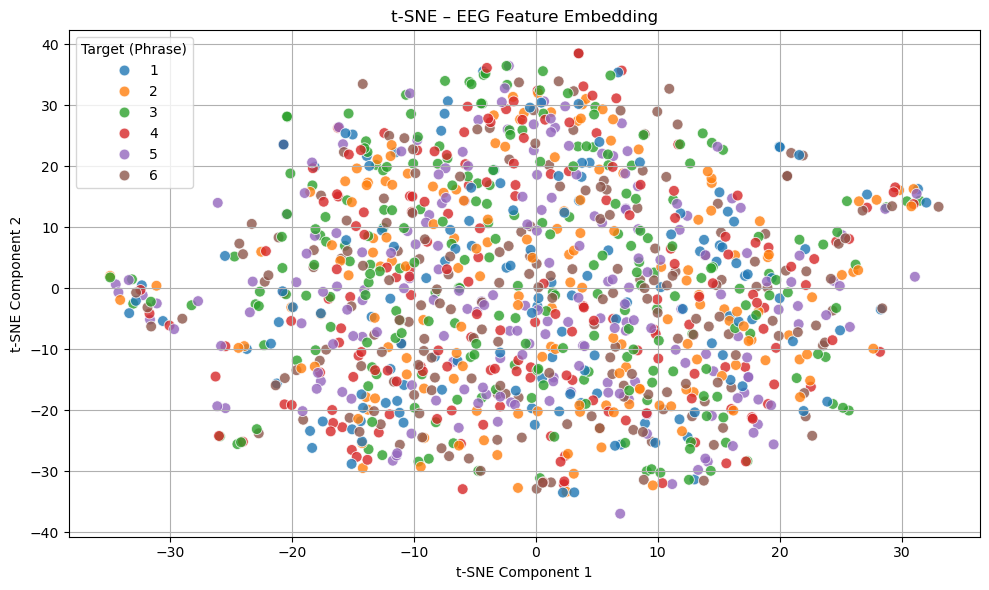

In [30]:
from sklearn.manifold import TSNE

# Prepare data
X_tsne = df_features.drop(columns=["target"])
y_tsne = df_features["target"]

# Apply t-SNE (it works better on normalized data)
X_scaled = StandardScaler().fit_transform(X_tsne)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Create DataFrame for plotting
df_tsne = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
df_tsne["target"] = y_tsne

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="TSNE-1", y="TSNE-2", hue="target", palette="tab10", s=60, alpha=0.8)
plt.title("t-SNE – EEG Feature Embedding")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Target (Phrase)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
import plotly.express as px

# Prepare data
X_tsne = df_features.drop(columns=["target"])
y_tsne = df_features["target"]

# Normalize
X_scaled = StandardScaler().fit_transform(X_tsne)

# Run t-SNE in 3D
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
X_embedded_3d = tsne_3d.fit_transform(X_scaled)

# Create DataFrame for plotly
df_tsne_3d = pd.DataFrame(X_embedded_3d, columns=["TSNE-1", "TSNE-2", "TSNE-3"])
df_tsne_3d["target"] = y_tsne.astype(str)  # Convert to string for color labels

# Plot with plotly
fig = px.scatter_3d(
    df_tsne_3d,
    x="TSNE-1",
    y="TSNE-2",
    z="TSNE-3",
    color="target",
    title="t-SNE 3D – EEG Features by Phrase Target",
    opacity=0.7,
    width=900,
    height=600
)

fig.update_traces(marker=dict(size=4))
fig.show()


In [32]:
def save_blocks_with_target(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.pkl"
        path = output_dir / filename
        block.to_pickle(path)
        print(f"✅ Block {i} saved at {path}")


In [33]:
target_dir = data_dir.parent / "first_dataset_with_target"
save_blocks_with_target(dfs_no_target_0, base_dir=target_dir)

✅ Block 1 saved at ../data/first_dataset_with_target/block_01.pkl
✅ Block 2 saved at ../data/first_dataset_with_target/block_02.pkl
✅ Block 3 saved at ../data/first_dataset_with_target/block_03.pkl
✅ Block 4 saved at ../data/first_dataset_with_target/block_04.pkl
✅ Block 5 saved at ../data/first_dataset_with_target/block_05.pkl
✅ Block 6 saved at ../data/first_dataset_with_target/block_06.pkl
✅ Block 7 saved at ../data/first_dataset_with_target/block_07.pkl
✅ Block 8 saved at ../data/first_dataset_with_target/block_08.pkl
✅ Block 9 saved at ../data/first_dataset_with_target/block_09.pkl
✅ Block 10 saved at ../data/first_dataset_with_target/block_10.pkl
✅ Block 11 saved at ../data/first_dataset_with_target/block_11.pkl
✅ Block 12 saved at ../data/first_dataset_with_target/block_12.pkl
✅ Block 13 saved at ../data/first_dataset_with_target/block_13.pkl
✅ Block 14 saved at ../data/first_dataset_with_target/block_14.pkl
✅ Block 15 saved at ../data/first_dataset_with_target/block_15.pkl
✅ Bl

In [38]:
import mne

def save_blocks_as_fif(blocks, base_dir, sfreq=125):
    eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4",
                    "O1", "O2", "F3", "F4", "Fz", "Pz", "P3", "P4"]

    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, df in enumerate(blocks, 1):
        # Extract only EEG data (shape: channels x time)
        data = df[eeg_channels].to_numpy().T

        # Create info and Raw objects
        info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types="eeg")
        raw = mne.io.RawArray(data, info)

        # Set standard montage
        raw.set_montage("standard_1020")

        # Save as .fif
        filename = f"block_{i:02d}_filtered_noTarget0.fif"
        path = output_dir / filename
        raw.save(path, overwrite=True)
        print(f"✅ Block {i} saved as FIF at {path}")


In [39]:
target_dir = data_dir.parent / "first_dataset_fif"
save_blocks_as_fif(dfs_no_target_0, base_dir=target_dir)

Creating RawArray with float64 data, n_channels=14, n_times=13827
    Range : 0 ... 13826 =      0.000 ...   110.608 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_01_filtered_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_01_filtered_noTarget0.fif
[done]
✅ Block 1 saved as FIF at ../data/first_dataset_fif/block_01_filtered_noTarget0.fif
Creating RawArray with float64 data, n_channels=14, n_times=14118
    Range : 0 ... 14117 =      0.000 ...   112.936 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_02_filtered_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_02_filtered_noTarget0.fif
[done]
✅ Block 2 saved as FIF at ../data/first_dataset_fif/block_02_filtered_noTarget0.fif
Creating RawArray with float64 data, n_channels=14, n_times=

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py:24: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_01_filtered_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py:24: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_02_filtered_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py

Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_14_filtered_noTarget0.fif
[done]
✅ Block 14 saved as FIF at ../data/first_dataset_fif/block_14_filtered_noTarget0.fif
Creating RawArray with float64 data, n_channels=14, n_times=14131
    Range : 0 ... 14130 =      0.000 ...   113.040 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_15_filtered_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_15_filtered_noTarget0.fif
[done]
✅ Block 15 saved as FIF at ../data/first_dataset_fif/block_15_filtered_noTarget0.fif
Creating RawArray with float64 data, n_channels=14, n_times=14132
    Range : 0 ... 14131 =      0.000 ...   113.048 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_16_filtered_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/n

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py:24: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_15_filtered_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py:24: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif/block_16_filtered_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/3043908745.py

In [40]:
import mne
import numpy as np
from pathlib import Path

def save_blocks_as_fif_with_metadata(blocks, base_dir, sfreq=125):
    eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4",
                    "O1", "O2", "F3", "F4", "Fz", "Pz", "P3", "P4"]

    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, df in enumerate(blocks, 1):
        # Dados EEG
        eeg_data = df[eeg_channels].to_numpy().T  # shape: (n_channels, n_times)

        # Metadados: target, time_sec, sample_index → adicionados como 'misc' channels
        extra_data = df[["target", "time_sec", "sample_index"]].to_numpy().T
        all_data = np.vstack([eeg_data, extra_data])

        # Define os tipos dos canais
        ch_names = eeg_channels + ["target", "time_sec", "sample_index"]
        ch_types = ["eeg"] * len(eeg_channels) + ["misc"] * 3

        # Cria o objeto info e Raw
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
        raw = mne.io.RawArray(all_data, info)

        # Montagem padrão 10-20
        raw.set_montage("standard_1020")

        # Salva
        filename = f"block_{i:02d}_withmeta_noTarget0.fif"
        path = output_dir / filename
        raw.save(path, overwrite=True)
        print(f"✅ Block {i} saved as FIF with metadata at {path}")


In [41]:
target_dir = data_dir.parent / "first_dataset_fif_with_meta"
save_blocks_as_fif_with_metadata(dfs_no_target_0, base_dir=target_dir)

Creating RawArray with float64 data, n_channels=17, n_times=13827
    Range : 0 ... 13826 =      0.000 ...   110.608 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_01_withmeta_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_01_withmeta_noTarget0.fif
[done]
✅ Block 1 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/block_01_withmeta_noTarget0.fif
Creating RawArray with float64 data, n_channels=17, n_times=14118
    Range : 0 ... 14117 =      0.000 ...   112.936 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_02_withmeta_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_02_withmeta_noTarget0.fif
[done]
✅ Block 2 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/bloc

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/1406592159.py:34: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_01_withmeta_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/1406592159.py:34: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_02_withmeta_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel

Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_09_withmeta_noTarget0.fif
[done]
✅ Block 9 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/block_09_withmeta_noTarget0.fif
Creating RawArray with float64 data, n_channels=17, n_times=14132
    Range : 0 ... 14131 =      0.000 ...   113.048 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_10_withmeta_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_10_withmeta_noTarget0.fif
[done]
✅ Block 10 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/block_10_withmeta_noTarget0.fif
Creating RawArray with float64 data, n_channels=17, n_times=14132
    Range : 0 ... 14131 =      0.000 ...   113.048 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/blo

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/1406592159.py:34: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_10_withmeta_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/1406592159.py:34: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_11_withmeta_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel

✅ Block 19 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/block_19_withmeta_noTarget0.fif
Creating RawArray with float64 data, n_channels=17, n_times=14064
    Range : 0 ... 14063 =      0.000 ...   112.504 secs
Ready.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_20_withmeta_noTarget0.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_20_withmeta_noTarget0.fif
[done]
✅ Block 20 saved as FIF with metadata at ../data/first_dataset_fif_with_meta/block_20_withmeta_noTarget0.fif


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_25752/1406592159.py:34: RuntimeWarning:

This filename (/Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../data/first_dataset_fif_with_meta/block_20_withmeta_noTarget0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

